## Generative modeling

Suppose we are given data $\mathcal{D}=\{x_i, y_i\}_{i=1}^n$, where $x_i\in \mathbb{R}^p, y_i=\{0,1,2...K\}$. 

## Linear discriminant analysis

In linear discriminant analysis, we model $X|y=k$ as a multivariate normal distribution $N(\mu_k, \mathbf{\Sigma})$. In particular,

$$\mathbb{P}\{x|y=k\} = \frac{1}{(2\pi)^{p/2}|\mathbf{\Sigma}|^{1/2}}\exp\bigg(-\frac{1}{2}(x-\mu_k)^T\mathbf{\Sigma}^{-1}(x-\mu_k)\bigg)$$

To estimate $\mu_k$ and $\mathbf{\Sigma}$, we use the maximum likelihood estimation. This gives us

$$\mu_k= \frac{1}{N_k}\sum_{i:y_i=k} x_i\;\;\;\;\;\;\;\;\;\;\mathbf{\Sigma} = \frac{1}{N}\sum_i (x_i-\mu_{y_i})(x_i-\mu_{y_i})^T$$

We them compute the posterior using Bayes rule

$$\mathbb{P}\{y=k|X=x\} = \frac{\pi_k \mathbb{P}\{x|y=k\}}{\sum_{i=0}^K \pi_i \mathbb{P}\{x|y=i\}}$$

Where $\pi_k$ denote the prior distribution and is estimated by

$$\pi_k = \frac{N_k}{N}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap

In [2]:
class LinearDiscriminantAnalysis:
    
    """
    LinearDiscriminantAnalysis:
    @ Params:
        p: number of features
        k: number of classes
    @ Variables:
        mu: list of means, each with dimension (p, )
        n: list of numbers of samples in class k
        N: total number of samples
        sigma: covariance matrix, each with dimension (p, )
    """
    
    def __init__(self, p, k): 
        self.p = p
        self.k = k
        self.mu = [np.zeros(p) for i in range(k)]
        self.n = [0 for i in range(k)]
        self.N = 0
        self.sigma = np.zeros((p, p))
    
    """
    fit: Given feature matrix X and response y, fit the parameters for LDA
    @ Input:
        X: Feature matrix of shape: (b, p), b denotes batch size
        y: Response vector of shape: (b, )
    """
    def fit(self, X, y):
        self.N = len(X)
        for i in range(self.N):
            self.n[y[i]] += 1
            self.mu[y[i]] += X[i]
        self.mu = [self.mu[i] / self.n[i] for i in range(self.k)]
        for i in range(self.N):
            x = X[i].reshape((self.p, 1))
            mu = self.mu[y[i]].reshape((self.p, 1))
            self.sigma += (x - mu) * (x - mu).T
        self.sigma = self.sigma / self.N
    
    """
    fit: Given testing feature matrix X, predict the class
    @ Input:
        X: Feature matrix of shape: (b, p), b denotes batch size
    @ Output:
        y: Predicted response of shape: (b, )
    """
    def predict(self, X):
        y = np.array([])
        for i in range(len(X)):
            logits = np.array([])
            for k in range(self.k):
                prob = multivariate_normal(mean=self.mu[k], cov=self.sigma).pdf(X[i])
                logits = np.append(logits, prob)
            y = np.append(y, logits.argmax())
        return y          

We now test our implementation. We randomly generate 150 sample points using three Gaussian distribution with different mean but same covariance matrix. The data points are then fitted using the LinearDiscriminantAnalysis class. The scatter plot of the sample data is also shown below.

In [3]:
mean1 = [1, 1]
mean2 = [-5, -1]
mean3 = [-2, 3]
cov = [[1, 0], [0, 3]]

class1 = np.random.multivariate_normal(mean1, cov, 50)
class2 = np.random.multivariate_normal(mean2, cov, 50)
class3 = np.random.multivariate_normal(mean3, cov, 50)

X = np.concatenate((class1, class2, class3), axis=0)
y = np.array([0] * 50 + [1] * 50 + [2] * 50)

print(f"Shape of feature matrix: {X.shape}")
print(f"Shape of response matrix: {y.shape}")

Shape of feature matrix: (150, 2)
Shape of response matrix: (150,)


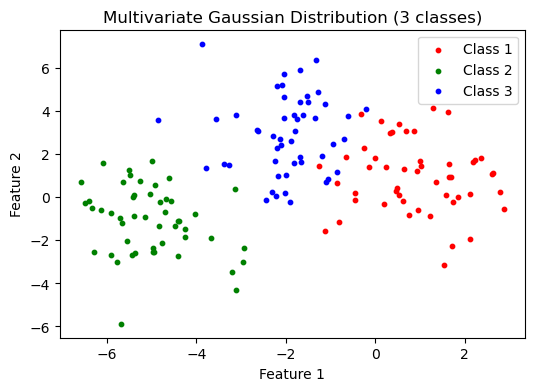

In [4]:
# Plotting the 3-class sample data
plt.figure(figsize=(6, 4))
plt.scatter(class1[:, 0], class1[:, 1], color='r', label='Class 1', s=10)
plt.scatter(class2[:, 0], class2[:, 1], color='g', label='Class 2', s=10)
plt.scatter(class3[:, 0], class3[:, 1], color='b', label='Class 3', s=10)
plt.title('Multivariate Gaussian Distribution (3 classes)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [5]:
# Fitting the lda model
lda = LinearDiscriminantAnalysis(2, 3)
lda.fit(X, y)

print(f"The estimated means are: {lda.mu[0]}, {lda.mu[1]}, {lda.mu[1]}")
print(f"The estimated covariance matrix is: [{lda.sigma[0]},")
print(f"                                     {lda.sigma[1]}]")

The estimated means are: [0.90063444 0.94480601], [-5.01030838 -1.09873138], [-5.01030838 -1.09873138]
The estimated covariance matrix is: [[ 0.91590837 -0.20251527],
                                     [-0.20251527  2.75043275]]


After fitting the data, we see that the estimated mean and covariance are pretty close to the ground truth. We can further visualize the decision boundary of lienar discriminant analysis and confirm that it is indeed linear.

In [6]:
h = 0.05

cmap_light = ListedColormap(['#FFAAAA66', '#AAFFAA66', '#AAAAFF66'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = -7, 3
y_min, y_max = -4.5, 7
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z).reshape(xx.shape)

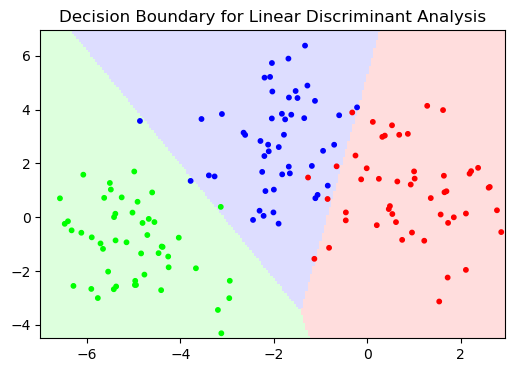

In [7]:
plt.figure(figsize=(6, 4))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision Boundary for Linear Discriminant Analysis")
plt.show()

## Quadratic discriminant analysis

In [8]:
class QuadraticDiscriminantAnalysis:
    
    """
    LinearDiscriminantAnalysis:
    @ Params:
        p: number of features
        k: number of classes
    @ Variables:
        mu: list of means, each with dimension (p, )
        n: list of numbers of samples in class k
        N: total number of samples
        sigma: list of covariance matrix, each with dimension (p, p)
    """
    
    def __init__(self, p, k): 
        self.p = p
        self.k = k
        self.mu = [np.zeros(p) for i in range(k)]
        self.n = [0 for i in range(k)]
        self.N = 0
        self.sigma = [np.zeros((p, p)) for i in range(k)]
    
    """
    fit: Given feature matrix X and response y, fit the parameters for LDA
    @ Input:
        X: Feature matrix of shape: (b, p), b denotes batch size
        y: Response vector of shape: (b, )
    """
    def fit(self, X, y):
        self.N = len(X)
        for i in range(self.N):
            self.n[y[i]] += 1
            self.mu[y[i]] += X[i]
        self.mu = [self.mu[i] / self.n[i] for i in range(self.k)]
        for i in range(self.N):
            x = X[i].reshape((self.p, 1))
            mu = self.mu[y[i]].reshape((self.p, 1))
            self.sigma[y[i]] += (x - mu) * (x - mu).T
        self.sigma = [self.sigma[i] / self.n[i] for i in range(self.k)]
    
    """
    fit: Given testing feature matrix X, predict the class
    @ Input:
        X: Feature matrix of shape: (b, p), b denotes batch size
    @ Output:
        y: Predicted response of shape: (b, )
    """
    def predict(self, X):
        y = np.array([])
        for i in range(len(X)):
            logits = np.array([])
            for k in range(self.k):
                prob = multivariate_normal(mean=self.mu[k], cov=self.sigma[k]).pdf(X[i])
                logits = np.append(logits, prob)
            y = np.append(y, logits.argmax())
        return y  

In [9]:
qda = QuadraticDiscriminantAnalysis(2, 3)
qda.fit(X, y)

In [10]:
Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z).reshape(xx.shape)

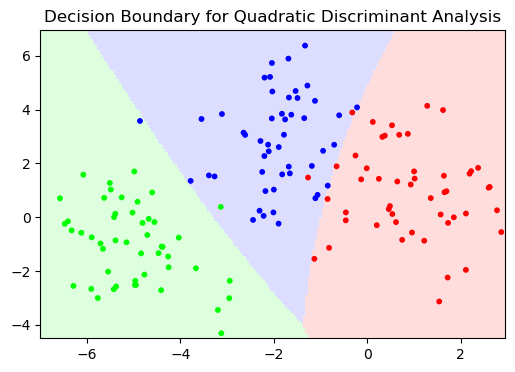

In [11]:
plt.figure(figsize=(6, 4))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision Boundary for Quadratic Discriminant Analysis")
plt.show()